# Speed Dating 

In this project we analyze the Speed Dating experiment dataset from Kaggle ([Source](https://www.kaggle.com/annavictoria/speed-dating-experiment/data)) to understand what attributes or interests one looks for in a potential partner. 
We also analyze one's perception of what the opposite sex looks for in them and if this experiment affected their confidence.

## Dataset Description

### Study Summary
Students of Columbia University were recruited to participate in a study ([Study](http://faculty.chicagobooth.edu/emir.kamenica/documents/genderDifferences.pdf))to understand their dating behaviour. Students were randomly divided into 21 waves to study different settings. Each student had to fill out a signup form with their personal details and few questions and a follow-up form after the event to re-evaluate the same questions asked at signup.

Each student spent 4 minutes with every participant of the opposite sex in that wave. They were given a scorecard to rate their partner and give a 'yes' or a 'no' decision at the end of the four minutes.

When both participants say a 'yes' it is considered a 'match'.

## Key findings

1) Descriptive Analysis Results 
xxxxxxxxxxx

2) Interest Classification on Major and Minor Race Groups
    We found out that for European/Caucasians, two groups get a high chance of their partner saying yes. One group is those who doesn’t like exercise but love clubbing, the other group is those who likes exercise and also likes dining. For the Black and African Americans, those who likes going to museums, regardless of whether they like or don’t like reading, get a high change of partners saying yes. 
    
3) Attributes Classification on Major and Minor Race Groups
    We found out that your partners' rating on your attractiveness is the most important factor that influence your partners' decision. For European/Caucasians, if you are attractive and have shared interests, your partners are likely to say yes. For the Black and African Americans, if you are attractive and fun, your partners are likely to say yes.

*Clustering*<br>
We initially tried clustering to see if we can find any correlation between the different attributes and interests. Kmeans with 3 clusters gave relatively the best results, however, the resulting clusters did not produce significant results.<br><br>

*Random Forest*<br>
We also tried using random forest model to identify the most significant features/interests that could be a determinant for a match. We used the important features that resulted from the model to plot into a decision tree and analyzed the results.<br>

Interest Classification: For the majority group, a person would likely get matched if he/she dislikes exercise but likes yoga, or likes exercise but not so much tvsports. For minority group, we got a match for those who likes yoga, but dislikes tv.<br>

Attributes Classification: For the majority group, attractiveness seems to be the most determinant feature, as it appears in the top and second level of the tree. Those who are attractive and shares alot of interests will get a match. For the minority group, attractiveness is still very important, but at a lower standard of 5.5 as compared to the 6.5 for the top level of majority tree. Those who are attractive and fun will get a match.<br>

The interests classification is very different for the KBest method and random forest, but the results for attributes classification both gives us the similar result that attractiveness, shared interest, and fun are three of the most important attributes for a person to get a match.<br>

**For detailed documentation on clustering and random forest, please see the Appendix notebook**
 

In [229]:
#Assumptions

In [230]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
import io
import requests
import datetime
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline

In [231]:
import sklearn as sk
import sklearn.tree as tree
import sklearn.preprocessing as pp
import sklearn.feature_selection as fs
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

In [327]:
data = pd.read_csv('Speed Dating Data.csv',encoding="ISO-8859-1").rename(columns=lambda x: x.strip())

###  Finding 1: Descriptive Analysis

To better understand the partitipants and the nature of the dataset here are few charts :

In [328]:
descrp=data.copy()

In [330]:
#dropping duplicates for each participant 
descrp=descrp.drop_duplicates(subset='iid', keep='first', inplace=False)
descrp.race.unique()

array([  4.,   2.,   6.,   3.,   1.,  nan])

#### a) Number of male and female participants in each wave

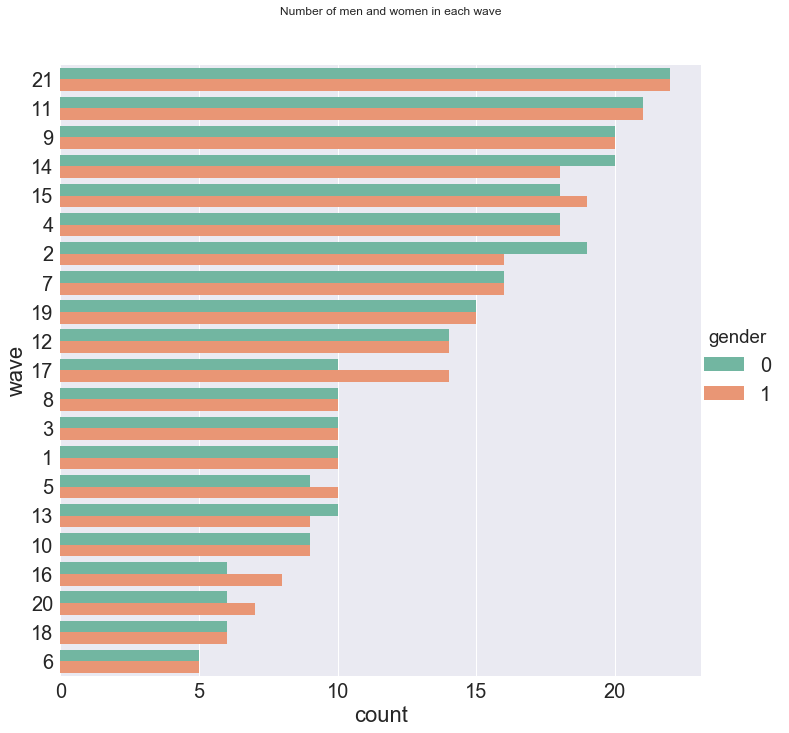

In [235]:
plot1= sns.factorplot(y="wave", hue='gender',data=descrp, size=10, kind="count", palette='Set2'\
                      ,orient='h',order=descrp['wave'].value_counts().index)
plt.subplots_adjust(top=0.9)
plot1.fig.suptitle('Number of men and women in each wave');

Most waves had equal number of men and women giving both the genders equal oppurtunity. Some waves like 2, 16, 17 had a disparity in their male and female numbers given one gender more choices to pick from .

#### b) Race of the participants

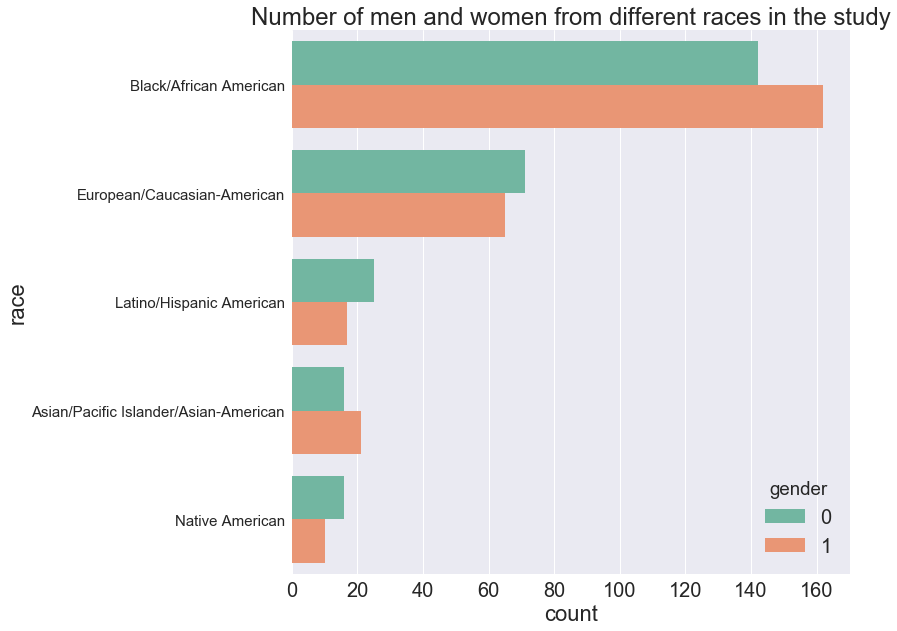

In [236]:
plot2 = plt.figure(figsize=(10,10))
plot2= sns.countplot(y='race',data=descrp, hue='gender',palette='Set2',\
                     order=descrp['race'].value_counts().index) # sorting by the count
plot2.set(yticklabels=race)
plot2.set_title('Number of men and women from different races in the study');
plot2 = plt.yticks(rotation=0,fontsize=15);

The participants of this study were mostly white. It is possible that there isn't a lot of diversity at Columbia university or the students most of the students who participated in this study were mostly white.
African Americans, Hispanics and Native Americans were the minorities in this study.

More white men participated in this experiment than white women.

In [237]:
#race= ['European/Caucasian-American','Asian/Pacific Islander/Asian-American',\
       #'Black/African American','Latino/Hispanic American','Native American','Other']

#### c) Participant's field of study

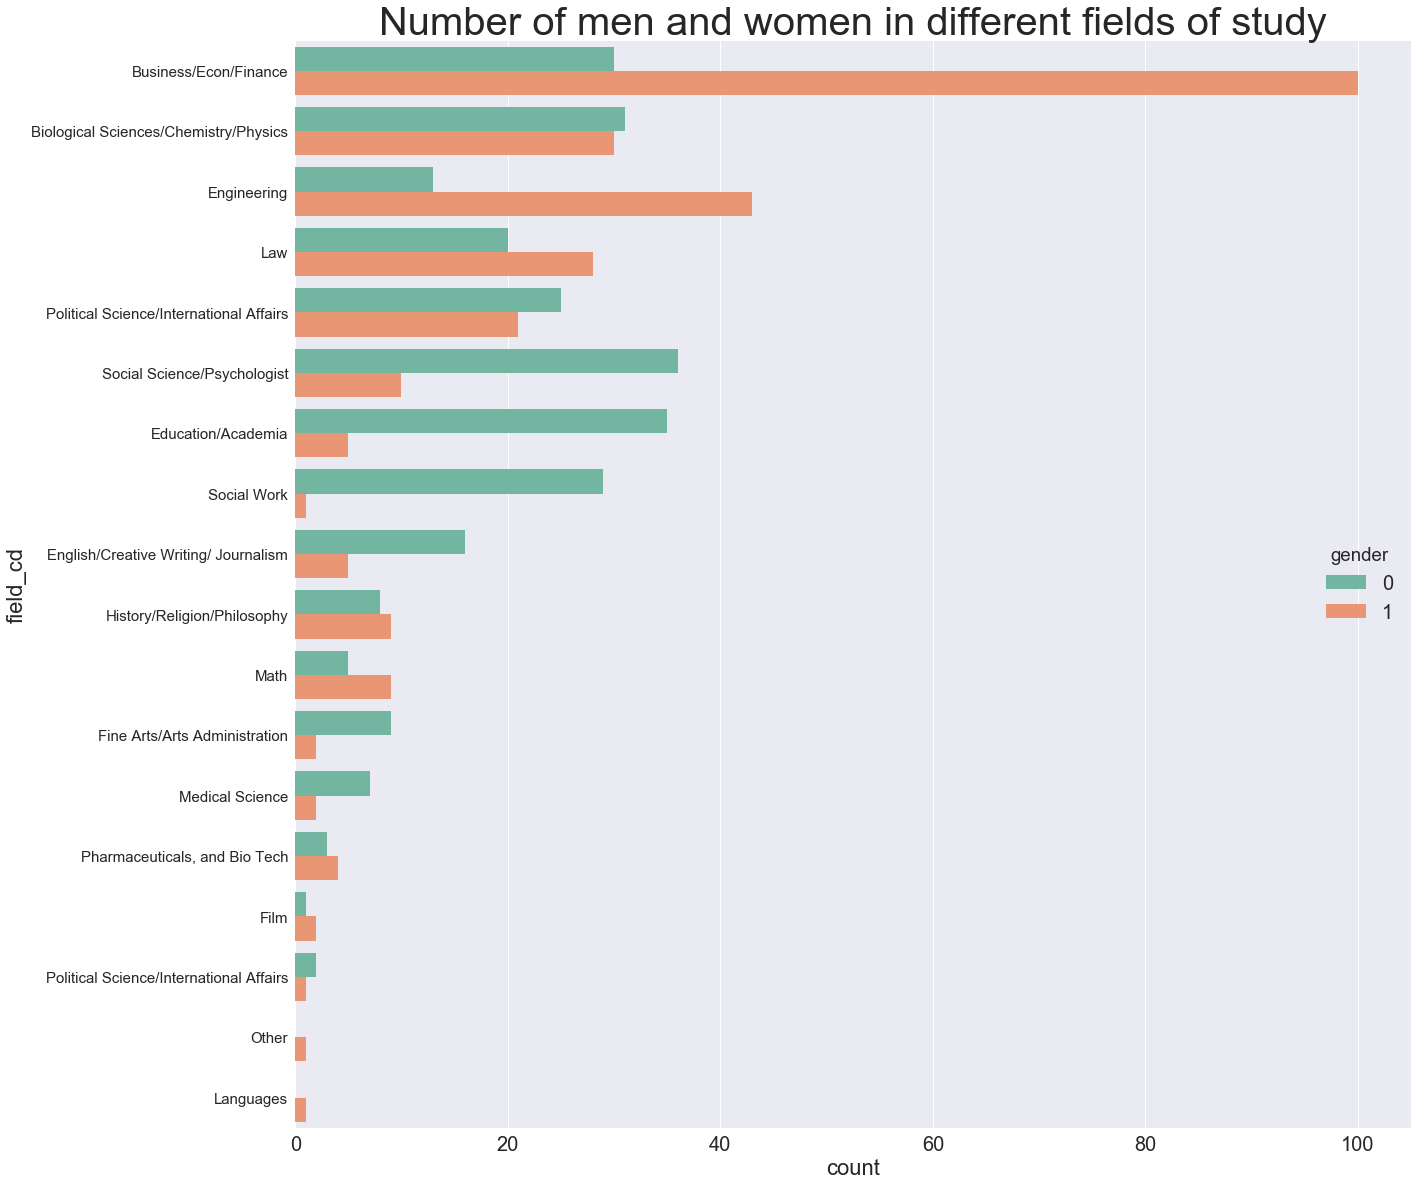

In [238]:
#The fields of study are
field_cd=['Business/Econ/Finance','Biological Sciences/Chemistry/Physics','Engineering','Law',\
          'Political Science/International Affairs','Social Science/Psychologist','Education/Academia'\
          ,'Social Work','English/Creative Writing/ Journalism','History/Religion/Philosophy','Math'\
          ,'Fine Arts/Arts Administration','Medical Science','Pharmaceuticals, and Bio Tech','Film',\
          'Political Science/International Affairs','Other','Languages','Architecture','Undergrad/undecided']

plot3 = plt.figure(figsize=(20,20))
plot3 = sns.countplot(y="field_cd",data=descrp, hue='gender', palette="Set2",\
                      order=descrp['field_cd'].value_counts().index) #sorting
plot3.set(yticklabels=field_cd)
plot3.set_title('Number of men and women in different fields of study', fontsize=40)
plot3 =plt.yticks(rotation=0,fontsize=15);

In [239]:
#field_cd = ['Law','Math','Social/Psy','MedicalScience,Pharmaceuticals,BioTech ',
              #     'Eng','Eglish/Creative Writing/ Journalism','History/Religion/Philosophy',
               #   'Business/Econ/Finance','Education, Academia','Biological Sciences/Chemistry/Physics',
                #  'Social Work','Undergrad/undecided','Political Science/International Affairs',
                 # 'Film','Fine Arts/Arts Administration','Languages','Architecture','Others']

Most male participants studied Business, Engineering and Law whereas most female participants studied Psychology, Education and Pure Sciences. A stark contrast is seen between male and female participants fields of study.

#### d) Activites the participants are interested in

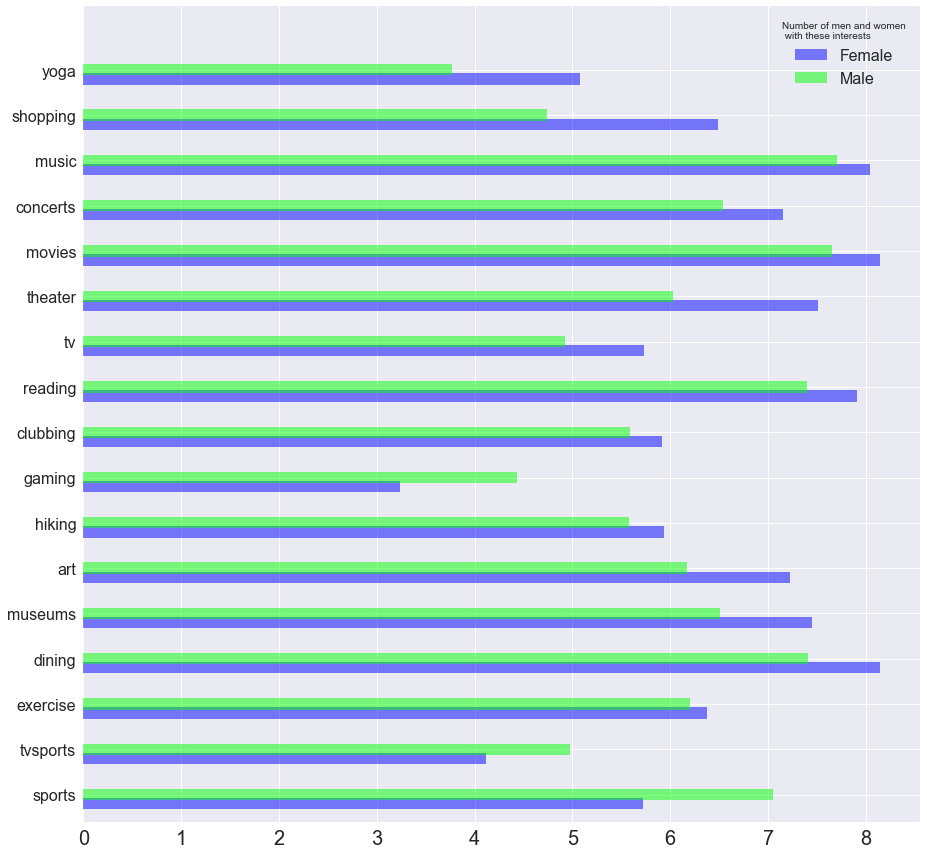

In [240]:
interests=['sports','tvsports','exercise','dining','museums','art','hiking','gaming','clubbing','reading',
                       'tv','theater','movies','concerts','music','shopping','yoga']
intact = descrp.groupby(['gender']).mean()[interests].values

plot4= plt.figure(figsize=(15,15))
plot4= plt.barh(np.arange(0,2*intact.shape[1],2)-0.2,intact[0,:], height=0.5,color=[0,0,1],alpha=0.5,label='Female')
plot4 = plt.barh(np.arange(0,2*intact.shape[1],2)+0.2,intact[1,:], height=0.5,color=[0,1,0],alpha=0.5,label='Male')
plot4 = plt.yticks(np.arange(0,2*intact.shape[1],2)+0.2,interests,fontsize=16)
plot4 = plt.ylim(-1,2*intact.shape[1]+1)
plot4 = plt.legend(loc=0,fontsize=16)
plot4.set_title('Number of men and women\n with these interests');

Music , movies and dining were rated high by women. Yoga , shopping, art, museums are enjoyed more by women.Women have rated most activies higher than men.
Music movies and reading were rated high by men . Men however enjoyed gaming,sports and Tv sports more than women did.

### <u>Cleanning data </u>

In [326]:
sd_org=data.copy()

array([  4.,   2.,   6.,   3.,   1.,  nan])

According to the paper, "Seven waves have been omitted: one because we imposed a maximum number of acceptances, two because we were unable to attract sufficient participants, and four because they involved an experimental intervention where participants were asked to bring their favorite book." We identified those 7 waves based data key provided and exluded them.

In [325]:
# select waves that had been used in the paper 
wave=[6,12,16,18,19,20,21]
sd = sd_org[~sd_org['wave'].isin(wave)]
sd.wave.unique()

array([ 1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 13, 14, 15, 17])

In [243]:
# convert income to numeric values
sd['income'] = sd['income'].str.replace(',', '')
sd['income']= pd.to_numeric(sd['income'])

In [244]:
# Drop those colunms for 'half way through' phase 
sd= sd.drop(['attr1_s', 'sinc1_s', 'intel1_s', 'fun1_s', 'amb1_s', 'shar1_s',
             'attr3_s', 'sinc3_s', 'intel3_s', 'fun3_s', 'amb3_s'],axis=1)

In [245]:
# Drop those colunms for 'follow-up 2' phase, becuase these were filled out after 3-4 
# weeks after the event. A lot of them were NaN values and we think that participants 
# might not remember very clearly by that time. 

sd= sd.drop(['attr1_3', 'sinc1_3', 'intel1_3', 'fun1_3', 'amb1_3', 'shar1_3',
             'attr2_3', 'sinc2_3', 'intel2_3', 'fun2_3', 'amb2_3', 'shar2_3',
             'attr3_3', 'sinc3_3', 'intel3_3', 'fun3_3', 'amb3_3',
             'attr4_3', 'sinc4_3', 'intel4_3', 'fun4_3', 'amb4_3', 'shar4_3',
             'attr5_3', 'sinc5_3', 'intel5_3', 'fun5_3', 'amb5_3', 
             'attr7_3', 'sinc7_3', 'intel7_3', 'fun7_3', 'amb7_3', 'shar7_3',],axis=1)

In [246]:
# Drop attr7_2, because it doesn't pair up with the question asked in the correspoding sign up phase.
sd= sd.drop('attr7_2',axis=1)

In [247]:
# Drop those columns that won't be used in this analysis 
sd= sd.drop(['id', 'idg', 'wave','round','condtn', 'position', 'positin1','partner','pid','int_corr',
             'age_o','race_o','from','zipcode','career','career_c','satis_2','length',
             'pf_o_att','pf_o_sin','pf_o_int','pf_o_fun','pf_o_amb','pf_o_sha','field',
             'undergra','mn_sat','tuition','exphappy','expnum','numdat_2','samerace',
             'match_es','you_call','them_cal','date_3','numdat_3','num_in_3'],axis=1)

In [248]:
# group those attributes suing 1-10 scales
ten = ['attr3_1', 'sinc3_1',
       'fun3_1', 'intel3_1', 'amb3_1', 'attr5_1', 'sinc5_1', 'intel5_1',
       'fun5_1', 'amb5_1','attr3_2', 'sinc3_2', 'intel3_2', 'fun3_2', 'amb3_2',
       'attr5_2', 'sinc5_2', 'intel5_2', 'fun5_2', 'amb5_2']

# group those attributes using 100 point system
hrd = ['attr1_1', 'sinc1_1',
       'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1', 'attr4_1', 'sinc4_1',
       'intel4_1', 'fun4_1', 'amb4_1', 'shar4_1', 'attr2_1', 'sinc2_1',
       'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1','sinc7_2', 'intel7_2', 'fun7_2', 'amb7_2',
       'shar7_2', 'attr1_2', 'sinc1_2', 'intel1_2', 'fun1_2', 'amb1_2',
       'shar1_2', 'attr4_2', 'sinc4_2', 'intel4_2', 'fun4_2', 'amb4_2',
       'shar4_2', 'attr2_2', 'sinc2_2', 'intel2_2', 'fun2_2', 'amb2_2',
       'shar2_2']

In [249]:
# Normalize two different scales 

# Normalize 10 point scale
sd[ten]=sd[ten].apply(lambda x: ((x-1)/9))

# Normalize 100 point scale
sd[hrd]=sd[hrd].apply(lambda x: x/100)

In [250]:
# final columns to keep 
sd.columns

Index(['iid', 'gender', 'order', 'match', 'dec_o', 'attr_o', 'sinc_o',
       'intel_o', 'fun_o', 'amb_o',
       ...
       'attr3_2', 'sinc3_2', 'intel3_2', 'fun3_2', 'amb3_2', 'attr5_2',
       'sinc5_2', 'intel5_2', 'fun5_2', 'amb5_2'],
      dtype='object', length=111)


### What do you look for in the opposite sex SIGNUP vs FOLLOWUP

Six attributes were asked to be ranked by each participant-  Attractive, Sincere,Intelligent,Fun,Ambitious and Shared Interests.
We wanted to know which attributes were given the most points by men and women at signup and followup to see if there are any differences in the gender or the two different times of the experiment.

In [251]:
#picking columns for the attributes from q1
signup=sd[['iid','gender','attr1_1','sinc1_1','intel1_1','fun1_1',\
        'amb1_1','shar1_1']]
followup=sd[['iid','gender','attr1_2','sinc1_2','intel1_2','fun1_2',\
        'amb1_2','shar1_2']]



In [252]:
#dropping any null values
signup=signup.dropna(axis=0,how='any')

followup=followup.dropna(axis=0,how='any')


In [253]:
#each participant filled out only one form at signup and followup , but met multiple people,
#hence the form values were duplicated in the dataset

#removing duplicate values
signup=signup.drop_duplicates(subset=None, keep='first', inplace=False)

followup=followup.drop_duplicates(subset=None, keep='first', inplace=False)


In [254]:
#melting the dataset to transfrom the 6 columns into 1
signupmelt=pd.melt(signup,id_vars=['gender'], value_vars=['attr1_1','sinc1_1','intel1_1','fun1_1',\
        'amb1_1','shar1_1'], var_name ='Attributes', value_name = 'AttributeValue')


followupmelt=pd.melt(followup,id_vars=['gender'], value_vars=['attr1_2','sinc1_2','intel1_2','fun1_2',\
        'amb1_2','shar1_2'], var_name ='Attributes', value_name = 'AttributeValue')


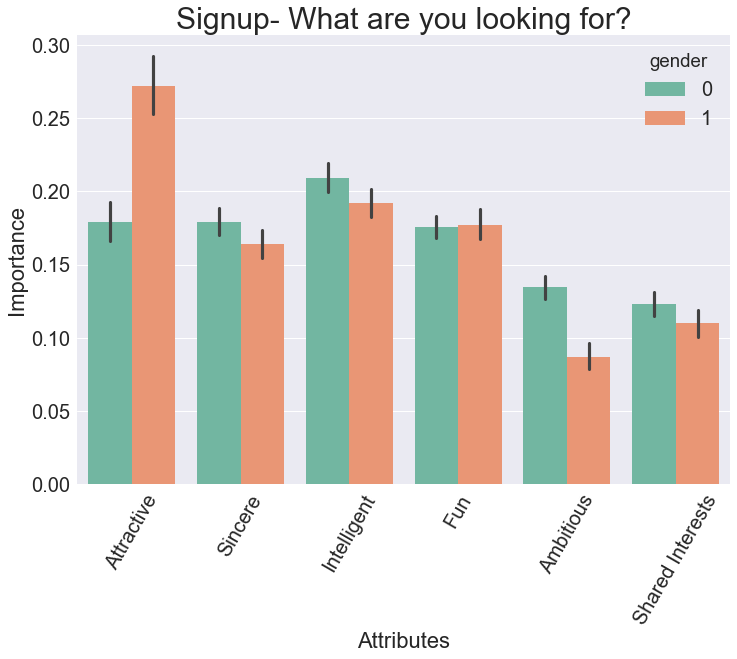

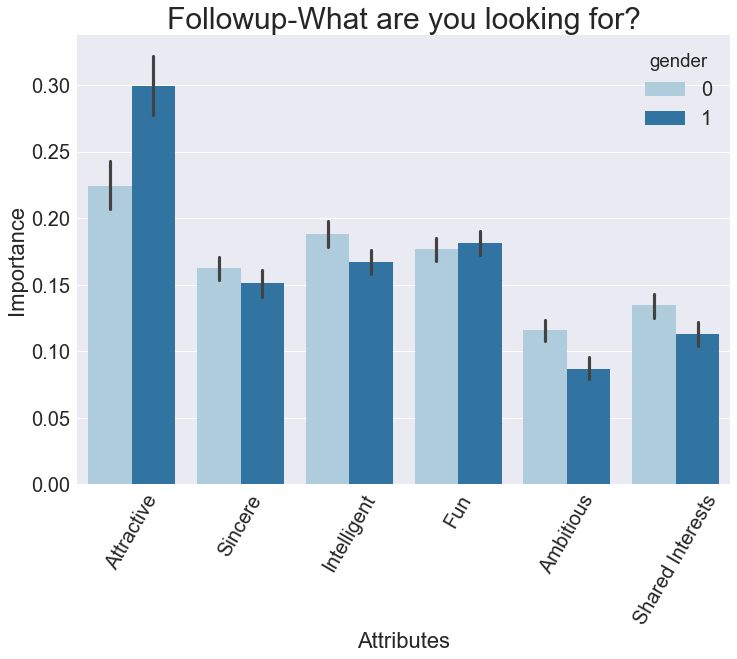

In [255]:
#plotting the highest rated attribute for signup and follow up

sns.set(font_scale = 2) #increasing the plot size
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)


plot5 = sns.barplot(x="Attributes", y="AttributeValue", hue="gender", data=signupmelt ,palette="Set2")
plot5.set(xlabel='Attributes', ylabel='Importance')
plot5.set_title("Signup- What are you looking for?",fontsize=30)
plot5.set_xticklabels(['Attractive','Sincere','Intelligent','Fun','Ambitious','Shared Interests'])#renaming the x axis ticks
plot5.set_xticklabels(plot5.get_xticklabels(),rotation=60)
plt.show();



#plotting the followup data
a4_dims = (11.7, 8.27) 
fig, ax = pyplot.subplots(figsize=a4_dims) 

plot6 = sns.barplot(x="Attributes", y="AttributeValue", hue="gender", data=followupmelt, palette="Paired")
plot6.set(xlabel='Attributes', ylabel='Importance')
plot6.set_title("Followup-What are you looking for?", fontsize=30)
plot6.set_xticklabels(['Attractive','Sincere','Intelligent','Fun','Ambitious','Shared Interests']) 
plot6.set_xticklabels(plot6.get_xticklabels(),rotation=60)
plt.show();

### Feature Selection for Men and Women at Signup vs Followup

#### Men

In [256]:
male=sd[sd.gender==1]

In [257]:
malesignup=male[['match','attr1_1','sinc1_1','intel1_1','fun1_1',\
        'amb1_1','shar1_1']]
malefollowup=male[['match','attr1_2','sinc1_2','intel1_2','fun1_2',\
        'amb1_2','shar1_2']]

In [258]:
malesignup=malesignup.dropna(axis=0,how='any')
malefollowup=malefollowup.dropna(axis=0,how='any')

In [259]:
X1, y1 = malesignup.drop(['match'], axis=1), malesignup['match']
X2, y2 = malefollowup.drop(['match'], axis=1), malefollowup['match']

In [260]:
#signup
kb = fs.SelectKBest(k=3)
kb.fit(X1, y1)  
names = X1.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])

#Sorting the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)



SelectKBest(k=3, score_func=<function f_classif at 0x108fbf8c8>)

  Feat_names  F_Scores
1    sinc1_1  7.777656
2    shar1_1  4.201647
0    attr1_1  3.609222


In [261]:
#followup
kb = fs.SelectKBest(k=3)
kb.fit(X2, y2)
names = X2.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])

#Sorting the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

SelectKBest(k=3, score_func=<function f_classif at 0x108fbf8c8>)

  Feat_names  F_Scores
1     fun1_2  14.42849
2     amb1_2   1.58611
0    sinc1_2   1.27101


#### Women

In [262]:
female=sd[sd.gender==0]

In [263]:
femalesignup=female[['match','attr1_1','sinc1_1','intel1_1','fun1_1',\
        'amb1_1','shar1_1']]

femalefollowup=female[['match','attr1_2','sinc1_2','intel1_2','fun1_2',\
        'amb1_2','shar1_2']]

In [264]:
femalesignup=femalesignup.dropna(axis=0,how='any')
femalefollowup=femalefollowup.dropna(axis=0,how='any')

In [265]:
X3,y3= femalesignup.drop(['match'], axis=1), femalesignup['match']
X4, y4 = femalefollowup.drop(['match'], axis=1), femalefollowup['match']

In [266]:
kb = fs.SelectKBest(k=3)
kb.fit(X3, y3)  
names = X3.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

SelectKBest(k=3, score_func=<function f_classif at 0x108fbf8c8>)

  Feat_names  F_Scores
2    shar1_1  8.660441
1     fun1_1  6.705976
0   intel1_1  1.303869


In [267]:
kb = fs.SelectKBest(k=3)
kb.fit(X4, y4) 
names = X4.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

SelectKBest(k=3, score_func=<function f_classif at 0x108fbf8c8>)

  Feat_names   F_Scores
1     fun1_2  12.409752
2     amb1_2   5.905993
0    sinc1_2   0.461899


### What do you think the opposite sex looks for 

In [268]:
#picking columns for the attributes from question 2
signup2=sd[['iid','gender','attr2_1','sinc2_1','intel2_1','fun2_1',\
        'amb2_1','shar2_1']]
followup2=sd[['iid','gender','attr2_2','sinc2_2','intel2_2','fun2_2',\
        'amb2_2','shar2_2']]

In [269]:
#dropping any null values
signup2=signup2.dropna(axis=0,how='any')

followup2=followup2.dropna(axis=0,how='any')


In [270]:
#each participant filled out only one form at signup and followup , but met multiple people,
#hence the form values were duplicated in the dataset

#removing duplicate valyes
signup2=signup2.drop_duplicates(subset=None, keep='first', inplace=False)

followup2=followup2.drop_duplicates(subset=None, keep='first', inplace=False)



In [271]:
#melting the dataset to transfrom the 6 columns into 1
signupmelt2=pd.melt(signup2,id_vars=['gender'], value_vars=['attr2_1','sinc2_1','intel2_1','fun2_1',\
        'amb2_1','shar2_1'], var_name ='Attributes', value_name = 'AttributeValue')


followupmelt2=pd.melt(followup2,id_vars=['gender'], value_vars=['attr2_2','sinc2_2','intel2_2','fun2_2',\
        'amb2_2','shar2_2'], var_name ='Attributes', value_name = 'AttributeValue')


AttributeError: 'FacetGrid' object has no attribute 'get_xticklabels'

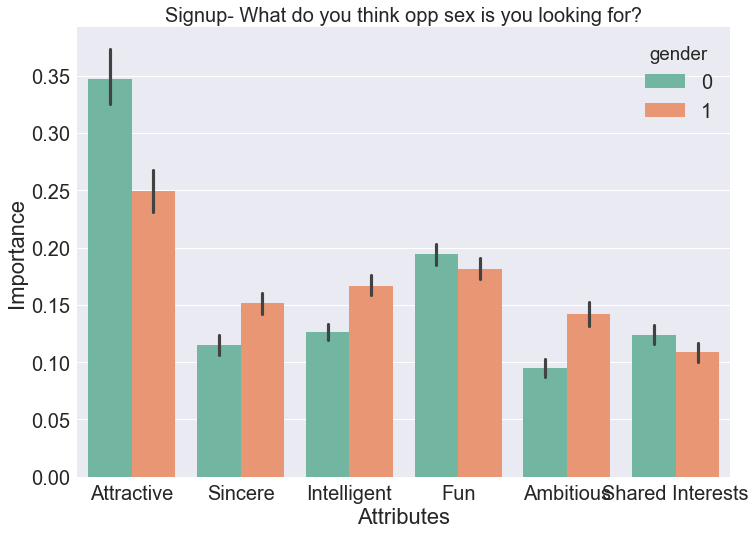

In [272]:
#plotting the highest rated attribute for signup and follow up

sns.set(font_scale = 2) #increasing the plot size
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)


plot7 = sns.barplot(x="Attributes", y="AttributeValue", hue="gender", data=signupmelt2,palette="Set2")
plot7.set(xlabel='Attributes', ylabel='Importance')
plot7.set_title("Signup- What do you think opp sex is you looking for?",fontsize=20)
plot7.set_xticklabels(['Attractive','Sincere','Intelligent','Fun','Ambitious','Shared Interests'])#renaming the x axis ticks
plot7.set_xticklabels(plot1.get_xticklabels(),rotation=60)
plt.show();



#plotting the followup data
a4_dims = (11.7, 8.27) 
fig, ax = pyplot.subplots(figsize=a4_dims) 

plot8 = sns.barplot(x="Attributes", y="AttributeValue", hue="gender", data=followupmelt2, palette="Paired")
plot8.set(xlabel='Attributes', ylabel='Importance')
plot8.set_title("Followup-What do you think opp sex is you looking for?",fontsize=20)
plot8.set_xticklabels(['Attractive','Sincere','Intelligent','Fun','Ambitious','Shared Interests']) 
plot8.set_xticklabels(plot2.get_xticklabels(),rotation=60)
plt.show();

 ### How do measure up signup vs followup?

In [ ]:
#picking columns for the attributes from question 2
signup3=sd[['iid','gender','attr3_1','sinc3_1','intel3_1','fun3_1',\
        'amb3_1']]
followup3=sd[['iid','gender','attr3_2','sinc3_2','intel3_2','fun3_2',\
        'amb3_2']]

In [ ]:
#dropping any null values
signup3=signup3.dropna(axis=0,how='any')

followup3=followup3.dropna(axis=0,how='any')

In [ ]:
#each participant filled out only one form at signup and followup , but met multiple people,
#hence the form values were duplicated in the dataset

#removing duplicate valyes
signup3=signup3.drop_duplicates(subset=None, keep='first', inplace=False)

followup3=followup3.drop_duplicates(subset=None, keep='first', inplace=False)

In [ ]:
#melting the dataset to transfrom the 6 columns into 1
signupmelt3=pd.melt(signup3,id_vars=['gender'], value_vars=['attr3_1','sinc3_1','intel3_1','fun3_1',\
        'amb3_1'], var_name ='Attributes', value_name = 'AttributeValue')


followupmelt3=pd.melt(followup3,id_vars=['gender'], value_vars=['attr3_2','sinc3_2','intel3_2','fun3_2',\
        'amb3_2'], var_name ='Attributes', value_name = 'AttributeValue')
signupmelt3.head()
followupmelt3.head()

In [ ]:
#plotting the highest rated attribute for signup and follow up

#sns.set(font_scale = 2) #increasing the plot size
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)


plot7 = sns.barplot(x="Attributes", y="AttributeValue", hue="gender", data=signupmelt3,palette="Set2")
plot7.set(xlabel='Attributes', ylabel='Importance')
plot7.set_title("Signup- What do you think opp sex is you looking for?",fontsize=20)
plot7.set_xticklabels(['Attractive','Sincere','Intelligent','Fun','Ambitious'])#renaming the x axis ticks
plot7.set_xticklabels(plot1.get_xticklabels(),rotation=60)

plt.show();



#plotting the followup data
a4_dims = (11.7, 8.27) 
fig, ax = pyplot.subplots(figsize=a4_dims) 

plot8 = sns.barplot(x="Attributes", y="AttributeValue", hue="gender", data=followupmelt3, palette="Paired")
plot8.set(xlabel='Attributes', ylabel='Importance')
plot8.set_title("Followup-What do you think opp sex is you looking for?",fontsize=20)
plot8.set_xticklabels(['Attractive','Sincere','Intelligent','Fun','Ambitious']) 
plot8.set_xticklabels(plot2.get_xticklabels(),rotation=60)

plt.show();

### <u>Clustering</u>


We wanted to cluster the dataset using participants' interests and character attributes from the sign up phase. Our initial approach was to check the correlations among these variables and dropped one variable in pairs with high correlations.

In [ ]:
# features we want to include in our analysis for sign up phase
features =['gender','match','order','age','field_cd','race','imprace','imprelig','date','go_out',
           'sports','tvsports','exercise','dining','museums','art','hiking','gaming',
           'clubbing','reading','tv','theater','movies','music','shopping','yoga',
           'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1',
           'attr2_1', 'sinc2_1','intel2_1', 'fun2_1', 'amb2_1', 'shar2_1', 'attr3_1',
           'sinc3_1','fun3_1', 'intel3_1', 'amb3_1']

In [ ]:
# correlations between features
sd[features].corr().head()

In [ ]:
# heatmap of the correlations
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(sd[features].corr(),linewidths=.5, ax=ax)

In [ ]:
# drop one feature in the pairs that have high correlations
keep =['gender','match','order','age','field_cd','race','imprace','income','date',
       'exercise','museums','hiking','gaming','clubbing','reading','tv','music','yoga',
       'sinc1_1', 'intel1_1','fun1_1', 'amb1_1', 'shar1_1','intel2_1', 'fun2_1',
       'sinc3_1','fun3_1', 'intel3_1']

In [ ]:
# run the heat map again to make sure the correlations are within a reasonable range 
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(sd[keep].corr(),linewidths=.5, ax=ax)

We decided to drop all NaN values instead of imputing them in some way, because these are all personal preference rankings, it doesn't make sense to impose the mean or median of other people's ranking to a specific participant who was either unwilling or unable to give the ranking at the time. 

In [ ]:
# drop all NaN values 
temp1 = sd[keep].dropna()

We compared 3 different clustering models using different numbers of clusters and trying to pick the best one. 

In [ ]:
# we got this code from Michele Samorani's Phython class note. See reference at the bottom.
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering

bestSil = -1
for k in range(2,6):
    clus = [KMeans(n_clusters=k,n_jobs=-1), Birch(n_clusters=k), 
            AgglomerativeClustering(n_clusters=k)]
    for cl in clus:
        res = cl.fit(temp1)
        sil = metrics.silhouette_score(temp1, res.labels_)
        print (str(cl)[:10] + ' with k =' +str(k) + ": " + str(round(sil,4)))
        if (sil > bestSil):
            bestSil = sil
            bestCl = cl

The results are very close. We were expecting something over 0.7 to give us better clusters. The number shows that KMeans with cluster of 3 is the best option here. 

In [ ]:
kmeans = KMeans(n_clusters=3)

In [ ]:
cluster = kmeans.fit_predict(temp1)

In [ ]:
temp1['cluster']=cluster

In [ ]:
temp1.groupby('cluster').mean()

The result was not that good. It did not give a fairly clear cluster. Also since our dateset has already been labeled, we decided to move to classification instead of clustering. 

### <u> Classification</u>

### Finding 2 Interests Classification

We wanted to see how your interests influence your partner's decision. We did this on two race groups to find out whether the interests that got you partner to say yes changed among different races. 

#### Description of the columns <br><br>


| Column | Description |
|--------|-------------|
|`dec_o`|1 = yes, 0 = no|
|`sports`|scale of 1-10|
|`tvsports`| scale of 1-10|
|`exercise`| scale of 1-10|
|`dining`| scale of 1-10|
|`museums`| scale of 1-10|
|`art`| scale of 1-10|
|`hiking`| scale of 1-10|
|`gaming`|scale of 1-10|
|`clubbing`|scale of 1-10|
|`reading`|scale of 1-10|
|`tv`|scale of 1-10|
|`theater`|scale of 1-10|
|`movies`|scale of 1-10|
|`music`|scale of 1-10|
|`shopping`|scale of 1-10|
|`yoga`|scale of 1-10|



In [333]:
# select interests
interest = ['dec_o','sports','tvsports','exercise','dining','museums','art','hiking',
            'gaming','clubbing','reading','tv','theater','movies','music','shopping',
            'yoga']

Classification over interest on major race group: European/Caucasian-American:


In [334]:
# include waves 1-14
# Majority group & interest 
wave_m_i = sd[sd['race']==2].loc[:, interest]

In [335]:
# check how many rows we have 
len(wave_m_i)
# see if there is any NaN values
wave_m_i.isnull().sum()

3654

dec_o        0
sports      16
tvsports    16
exercise    16
dining      16
museums     16
art         16
hiking      16
gaming      16
clubbing    16
reading     16
tv          16
theater     16
movies      16
music       16
shopping    16
yoga        16
dtype: int64

In [336]:
# drop all NaN values
wave_m_i=wave_m_i.dropna(axis=0, how='any')

In [337]:
# define our X and y
X_m_i, y_m_i = wave_m_i.drop(['dec_o'], axis=1), wave_m_i['dec_o']

kb = fs.SelectKBest(k=5)
kb.fit(X_m_i, y_m_i)

names = X_m_i.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

SelectKBest(k=5, score_func=<function f_classif at 0x108fbf8c8>)

  Feat_names   F_Scores
0   exercise  28.897477
1     dining  21.748872
2   clubbing  18.565484
4   shopping  16.132498
3    reading  12.118425


In [338]:
# best interests according to kbest
interest_best = ['dec_o','dining','clubbing','shopping','exercise','reading']

wave_m_i = sd[sd['race']==2].loc[:, interest_best]

In [339]:
wave_m_i=wave_m_i.dropna(axis=0, how='any')

In [340]:
# define X and y
X_m_i, y_m_i = wave_m_i.drop(['dec_o'], axis=1), wave_m_i['dec_o']
# to see the distribution of y 
len(wave_m_i[wave_m_i['dec_o']==1])
len(wave_m_i[wave_m_i['dec_o']==0])

1664

1974

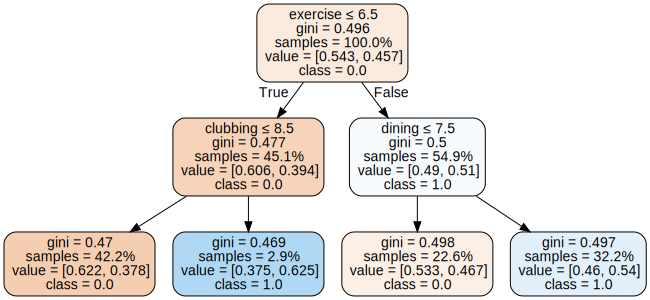

In [341]:
dtc = tree.DecisionTreeClassifier(max_depth=2).fit(X_m_i, y_m_i)
import graphviz
dot_data = sk.tree.export_graphviz(dtc, out_file=None, 
                         feature_names=list(X_m_i.columns),  
                       
                         class_names = ['1.0' if i == 1 else '0.0' for i in dtc.classes_] ,
                      
                         filled=True, rounded=True,  
                         special_characters=True, 
                         proportion=True,
                        )  
graph = graphviz.Source(dot_data)  
graph

We see that for the majority group, those who doesn’t like exercise but are into clubbing get a high possibitiy of yes from partners, same with those who likes exercise and likes dining out. Ginis are not very good here. We will try to improve them later. 

Classification over interest on minor race group: Black/African American:

In [342]:
wave_n_i = sd[(sd['race']==1)].loc[:, interest]

In [343]:
wave_n_i=wave_n_i.dropna(axis=0, how='any')

X_n_i, y_n_i = wave_n_i.drop(['dec_o'], axis=1), wave_n_i['dec_o']

kb = fs.SelectKBest(k=5)
kb.fit(X_n_i, y_n_i)

SelectKBest(k=5, score_func=<function f_classif at 0x108fbf8c8>)

In [344]:
# list out the 5 interests that Kbest chose
names = X_n_i.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

  Feat_names   F_Scores
2     hiking  36.192543
0    museums  17.223820
1        art  13.870620
4       yoga   8.376817
3    reading   8.220813


In [345]:
# best interests according to kbest
interest_best = ['dec_o','hiking','museums','art','reading','yoga']
wave_n_i = sd[(sd['race']==1)].loc[:, interest_best]

In [346]:
wave_n_i=wave_n_i.dropna(axis=0, how='any')

In [347]:
# define X and y
X_n_i, y_n_i = wave_n_i.drop(['dec_o'], axis=1), wave_n_i['dec_o']
# to see the distribution of y
len(wave_n_i[wave_n_i['dec_o']==1])
len(wave_n_i[wave_n_i['dec_o']==0])

143

218

In [348]:
dtc = tree.DecisionTreeClassifier(max_depth=2).fit(X_n_i, y_n_i)

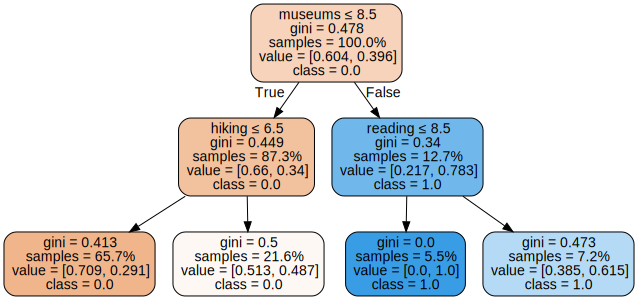

In [349]:
dot_data = sk.tree.export_graphviz(dtc, out_file=None, 
                         feature_names=list(X_n_i.columns),  
                        #class_names = ['1.0' if i == 1 else '0.0' for i in y.unique()] ,
                         class_names = ['1.0' if i == 1 else '0.0' for i in dtc.classes_] ,
                        #class_names =[i for i in temp1['match'].unique()],
                         filled=True, rounded=True,  
                         special_characters=True, 
                         proportion=True,
                        )  
graph = graphviz.Source(dot_data)  
graph

The decision tree shows that those who likes going to museums will get a match, regardless of whether they like or don’t like reading. We got a pure class here, which is those love museums and are not super into reading. They will 'defenitely' get a match.


### Finding 3: Attributes Classification

We did the same thing over attributes to see how your partner's rating on you influence his/her decision. We also did this on two race groups to find out whether the attributes that got you partner to say yes changed among different races. 

Classification over attributes on major race group: European/Caucasian-American

In [350]:
attributes=['dec_o','gender','attr_o', 'sinc_o', 'intel_o','fun_o', 
            'amb_o', 'shar_o','prob_o','met_o']

In [351]:
wave_m_a = sd[sd['race']==2].loc[:, attributes]

In [352]:
wave_m_a=wave_m_a.dropna(axis=0, how='any')

In [353]:
# define X and y
X_m_a, y_m_a = wave_m_a.drop(['dec_o'], axis=1), wave_m_a['dec_o']

In [354]:
kb = fs.SelectKBest(k=4)
kb.fit(X_m_a, y_m_a)

names = X_m_a.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

SelectKBest(k=4, score_func=<function f_classif at 0x108fbf8c8>)

  Feat_names    F_Scores
0     attr_o  918.213659
1      fun_o  643.311543
2     shar_o  553.036362
3     prob_o  341.224529


In [355]:
# best attributes according to kbest
attributes_best = ['dec_o','attr_o','fun_o', 'shar_o','prob_o']

In [356]:
wave_m_a = sd[sd['race']==2].loc[:, attributes_best]

In [357]:
wave_m_a=wave_m_a.dropna(axis=0, how='any')

In [358]:
X_m_a, y_m_a = wave_m_a.drop(['dec_o'], axis=1), wave_m_a['dec_o']
# distribution of y
len(wave_m_a[wave_m_a['dec_o']==1])
len(wave_m_a[wave_m_a['dec_o']==0])

1447

1630

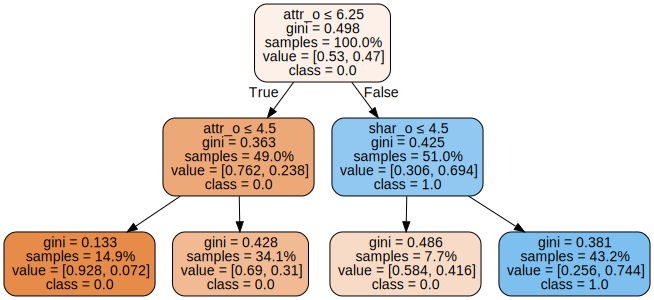

In [359]:
dtc = tree.DecisionTreeClassifier(max_depth=2).fit(X_m_a, y_m_a)

dot_data = sk.tree.export_graphviz(dtc, out_file=None, 
                         feature_names=list(X_m_a.columns),  
                         class_names = ['1.0' if i == 1 else '0.0' for i in dtc.classes_] ,
                        #class_names =[i for i in temp1['match'].unique()],
                         filled=True, rounded=True,  
                         special_characters=True, 
                         proportion=True,
                        )  
graph = graphviz.Source(dot_data)  
graph

Classification over attributes on minor race group: Black/African American:

In [360]:
wave_n_a = sd[(sd['race']==1)].loc[:, attributes]

In [361]:
wave_n_a=wave_n_a.dropna(axis=0, how='any')
# define X and y
X_n_a, y_n_a = wave_n_a.drop(['dec_o'], axis=1), wave_n_a['dec_o']

In [362]:
kb = fs.SelectKBest(k=4)
kb.fit(X_n_a, y_n_a)

names = X_n_a.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

SelectKBest(k=4, score_func=<function f_classif at 0x108fbf8c8>)

  Feat_names   F_Scores
0     attr_o  61.687932
1      fun_o  50.253904
2     shar_o  44.618446
3     prob_o  29.139577


In [363]:
# best attributes according to kbest
attributes_best = ['dec_o','attr_o','fun_o', 'shar_o','prob_o']
wave_n_a = sd[(sd['race']==1)].loc[:, attributes_best]

In [364]:
wave_n_a=wave_n_a.dropna(axis=0, how='any')

In [365]:
# define X and y
X_n_a, y_n_a = wave_n_a.drop(['dec_o'], axis=1), wave_n_a['dec_o']
# distribution of y
len(wave_n_a[wave_n_a['dec_o']==1])
len(wave_n_a[wave_n_a['dec_o']==0])

127

191

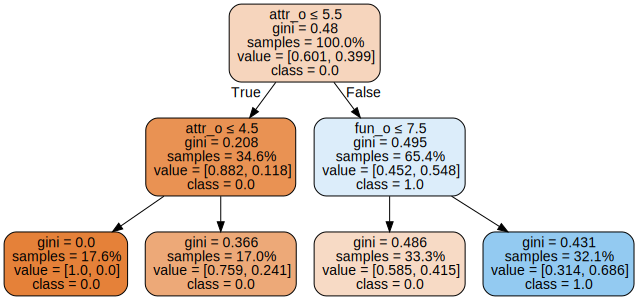

In [366]:
dtc = tree.DecisionTreeClassifier(max_depth=2).fit(X_n_a, y_n_a)


dot_data = sk.tree.export_graphviz(dtc, out_file=None, 
                         feature_names=list(X_n_a.columns),  
                         class_names = ['1.0' if i == 1 else '0.0' for i in dtc.classes_] ,
                        #class_names =[i for i in temp1['match'].unique()],
                         filled=True, rounded=True,  
                         special_characters=True, 
                         proportion=True,
                        )  
graph = graphviz.Source(dot_data)  
graph

The results suggest that attractiveness is the most important trait that will get you a match; specifically, if you are attractive and have shared interests, this will get you a match. for the minority group, if you are attractive and fun, you will get a match.

As we can see the ginis for interest classification on the major race group are all close to 0.5. In order to get better classification, we will further divide the major race group into people who rated exercise greater than 6.5 and those less or equal to 6.5. Then run the classification on attributes. 

In [367]:
# major race group who rated exercise >= 6.5
exercise = sd[(sd['race']==2) & (sd['exercise']>6.5)]
# major race group who rated exercise < 6.5
exercise1 = sd[(sd['race']==2) & (sd['exercise']<=6.5)]

In [368]:
exercise=exercise.loc[:, attributes]

In [369]:
exercise=exercise.dropna(axis=0, how='any')

In [370]:
X_m_e, y_m_e = exercise.drop(['dec_o'], axis=1), exercise['dec_o']

In [288]:
kb = fs.SelectKBest(k=4)
kb.fit(X_m_e, y_m_e)

names = X_m_e.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

SelectKBest(k=4, score_func=<function f_classif at 0x108fbf8c8>)

  Feat_names    F_Scores
0     attr_o  404.735121
1      fun_o  319.200852
2     shar_o  284.468469
3     prob_o  215.488513


In [371]:
attributes_best = ['dec_o','attr_o','fun_o', 'shar_o','prob_o']
exercise =exercise.loc[:, attributes_best]

In [372]:
exercise=exercise.dropna(axis=0, how='any')

In [373]:
X_m_e, y_m_e = exercise.drop(['dec_o'], axis=1), exercise['dec_o']

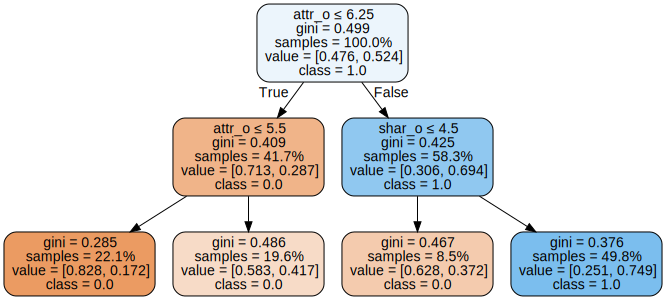

In [374]:
dtc = tree.DecisionTreeClassifier(max_depth=2).fit(X_m_e, y_m_e)


dot_data = sk.tree.export_graphviz(dtc, out_file=None, 
                         feature_names=list(X_m_e.columns),  
                         class_names = ['1.0' if i == 1 else '0.0' for i in dtc.classes_] ,
                        #class_names =[i for i in temp1['match'].unique()],
                         filled=True, rounded=True,  
                         special_characters=True, 
                         proportion=True,
                        )  
graph = graphviz.Source(dot_data)  
graph

Ginis do not improve much compared to the result using all major race data. Classes don't change either: attrictiveness is still the most prominent variable here, then is shared interest. Next we will look at major race group who rated excerice less than 6.5.

In [295]:
exercise1=exercise1.loc[:, attributes]
exercise1=exercise1.dropna(axis=0, how='any')
X_m_e, y_m_e = exercise1.drop(['dec_o'], axis=1), exercise1['dec_o']
kb = fs.SelectKBest(k=4)
kb.fit(X_m_e, y_m_e)

names = X_m_e.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

SelectKBest(k=4, score_func=<function f_classif at 0x108fbf8c8>)

  Feat_names    F_Scores
0     attr_o  466.204979
1      fun_o  296.326366
2     shar_o  249.156106
3     prob_o  121.010853


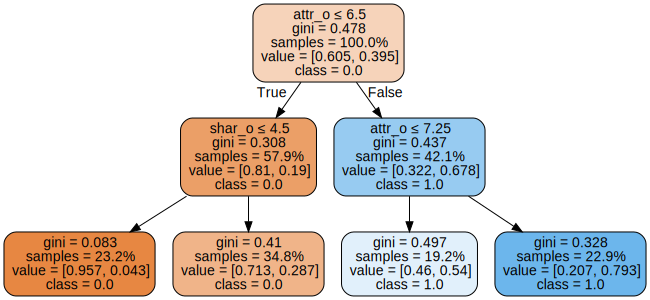

In [296]:
attributes_best = ['dec_o','attr_o','fun_o', 'shar_o','prob_o']
exercise1 =exercise1.loc[:, attributes_best]
exercise1=exercise1.dropna(axis=0, how='any')
X_m_e, y_m_e = exercise1.drop(['dec_o'], axis=1), exercise1['dec_o']
dtc = tree.DecisionTreeClassifier(max_depth=2).fit(X_m_e, y_m_e)


dot_data = sk.tree.export_graphviz(dtc, out_file=None, 
                         feature_names=list(X_m_e.columns),  
                         class_names = ['1.0' if i == 1 else '0.0' for i in dtc.classes_] ,
                         filled=True, rounded=True,  
                         special_characters=True, 
                         proportion=True,
                        )  
graph = graphviz.Source(dot_data)  
graph

Ginis improved a little bit compared to the result using all major race data. Now we can see for major race group, if you don't like exercise that much, attrictiveness is the ultimate variable that determines your partner's decision.

Now we are going to do the same thing to minor race group. We will divide this group according to their museum rating to one group less or equal to 8.5 and another one greater than 8.5.

In [321]:
# minor race group who rated museum > 8.5
museum = sd[(sd['race']==1) & (sd['museums']>8.5)]
# minor race group who rated museum <= 8.5
museum1 = sd[(sd['race']==1) & (sd['museums']<=8.5)]

In [305]:
museum =museum.loc[:, attributes]
museum =museum.dropna(axis=0, how='any')
X_n_e, y_n_e = museum.drop(['dec_o'], axis=1), museum['dec_o']
kb = fs.SelectKBest(k=4)
kb.fit(X_n_e, y_n_e)

names = X_n_e.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

SelectKBest(k=4, score_func=<function f_classif at 0x108fbf8c8>)

  Feat_names   F_Scores
0     attr_o  61.687932
1      fun_o  50.253904
2     shar_o  44.618446
3     prob_o  29.139577


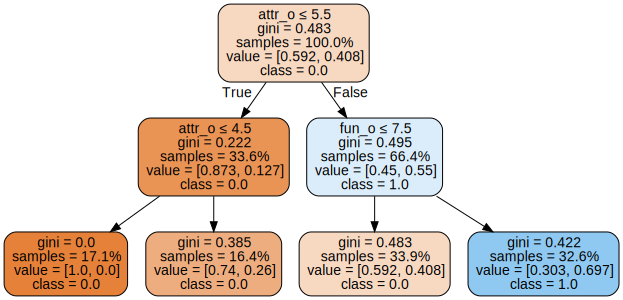

In [306]:
attributes_best = ['dec_o','attr_o','fun_o', 'shar_o','prob_o']
museum =museum.loc[:, attributes_best]
museum=museum.dropna(axis=0, how='any')
X_n_e, y_n_e = museum.drop(['dec_o'], axis=1), museum['dec_o']
dtc = tree.DecisionTreeClassifier(max_depth=2).fit(X_n_e, y_n_e)


dot_data = sk.tree.export_graphviz(dtc, out_file=None, 
                         feature_names=list(X_n_e.columns),  
                         class_names = ['1.0' if i == 1 else '0.0' for i in dtc.classes_] ,
                         filled=True, rounded=True,  
                         special_characters=True, 
                         proportion=True,
                        )  
graph = graphviz.Source(dot_data)  
graph

The classes and ginis are pretty much the same as we use the whole minor race group data. Let's double check using data who rated museum less or equal to 8.5

In [331]:
museum1 =museum1.loc[:, attributes]
museum1 =museum1.dropna(axis=0, how='any')
X_n_e, y_n_e = museum1.drop(['dec_o'], axis=1), museum1['dec_o']
kb = fs.SelectKBest(k=4)
kb.fit(X_n_e, y_n_e)

names = X_n_e.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

SelectKBest(k=4, score_func=<function f_classif at 0x108fbf8c8>)

  Feat_names   F_Scores
0     attr_o  46.041898
1      fun_o  43.184165
2     shar_o  42.261049
3     prob_o  27.262794


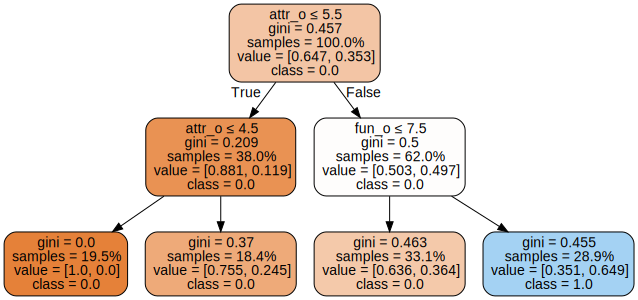

In [332]:
attributes_best = ['dec_o','attr_o','fun_o', 'shar_o','prob_o']
museum1 =museum1.loc[:, attributes_best]
museum1=museum1.dropna(axis=0, how='any')
X_n_e, y_n_e = museum1.drop(['dec_o'], axis=1), museum1['dec_o']
dtc = tree.DecisionTreeClassifier(max_depth=2).fit(X_n_e, y_n_e)


dot_data = sk.tree.export_graphviz(dtc, out_file=None, 
                         feature_names=list(X_n_e.columns),  
                         class_names = ['1.0' if i == 1 else '0.0' for i in dtc.classes_] ,
                         filled=True, rounded=True,  
                         special_characters=True, 
                         proportion=True,
                        )  
graph = graphviz.Source(dot_data)  
graph

The classes are the same but ginis get wrose instead. 

As we can see, even after further division of data into different sub groups based on the interest classifications, the results stays almost the same. How attrictive you are in your partner's eyes has the biggest impact on his/her decision of saying yes or no for both major and minor race group. If your attrictive score is high and you share quite a few interests with your partner, then the chance of his/her saying yes is high.

# Reference

Clustering: https://github.com/samorani/Data-Science-Analysis-with-Python

Descriptive analysis : https://www.kaggle.com/piecurus/a-gender-perspective-of-participants

https://seaborn.pydata.org/generated/seaborn.countplot.html